In [1]:
import import_src
from pybroker.order_broker import Broker
from pybroker.broker_vis import *
from pybroker.models import *
from pybroker.agents import *
import numpy as np
import random
import pandas as pd
from datetime import datetime

In [2]:
# Create a broker, and a market for ACME stock
asset = "ACME"
broker = Broker()
broker.create_market(asset)

In [3]:
# Create a group of agents with different trading strategies, and fund their accounts
# Have each agent trade for a fixed number of iterations, and then summarize the results

# traderId - Agent mapping
all_agents: dict[int, Agent] = {
    1: Arbitrage(),
    2: RevertToMean(),
}
num_random_trend_followers: int = 3
for i in range(num_random_trend_followers):
    traderId: int = 100 + i
    all_agents[traderId] = RandomTrendFollower(
        order_size_k=3,
    )

num_random_monkeys: int = 1
for i in range(num_random_monkeys):
    traderId: int = 200 + i
    all_agents[traderId] = RandomMonkey(
        mean_bid=100,
        bid_std=4,
        mean_ask=100,
        ask_std=4,
        order_size_k=3,
    )

num_ffnns: int = 2
for i in range(num_ffnns):
    traderId: int = 300 + i
    all_agents[traderId] = FeedForwardNeuralNetwork()


starting_cash: int = 100000
starting_assets: int = 1000

for traderId, agent in all_agents.items():
    broker.open_account(traderId)
    broker.deposit_cash(traderId, starting_cash)
    broker.deposit_asset(traderId, starting_assets, asset)

num_iterations: int = 2000

In [4]:
start_time = datetime.now()

for i in range(num_iterations):
    shuffled_traderIds = list(all_agents.keys())
    random.shuffle(shuffled_traderIds)
    for traderId in shuffled_traderIds:
        agent = all_agents[traderId]
        observations:Observations = observe(broker, traderId, asset)
        actions = agent.policy(observations)
        for order in actions.orders:
            try:
                broker.place_order(asset, order)
            except Exception as e:
                pass  # Order failed, skip

    if i % 100 == 0:
        broker.end_trading_day()

end_time = datetime.now()
duration = end_time - start_time
print(f"Simulated {num_iterations} iterations in {duration.total_seconds()} seconds.")
print(f"Orders per second: {num_iterations * len(all_agents)/ duration.total_seconds()}")

Simulated 2000 iterations in 14.192112 seconds.
Orders per second: 1127.3868188187917


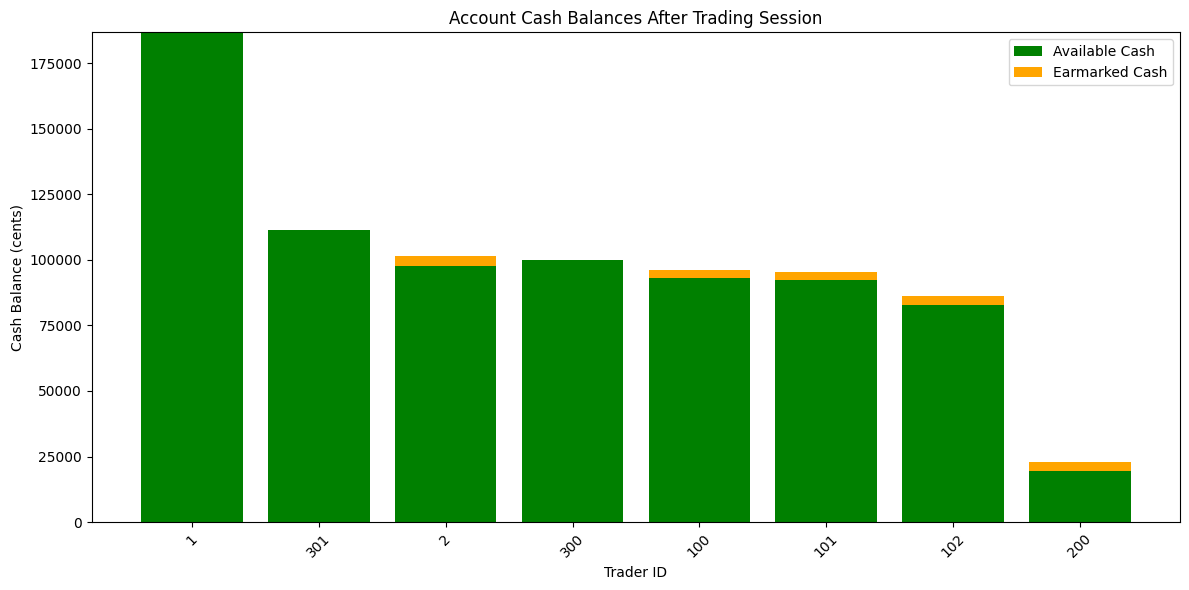

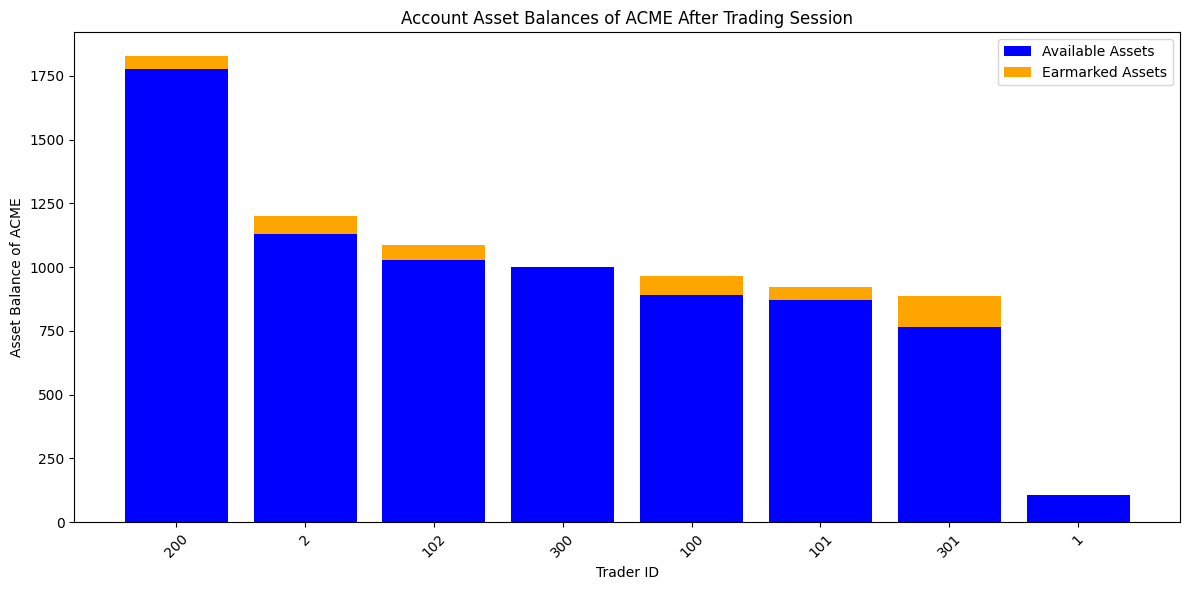

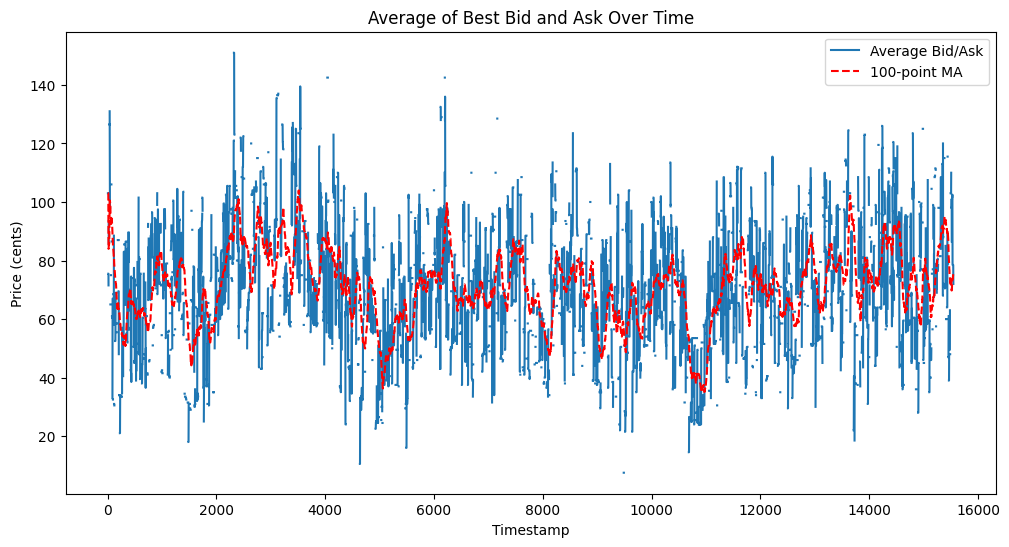

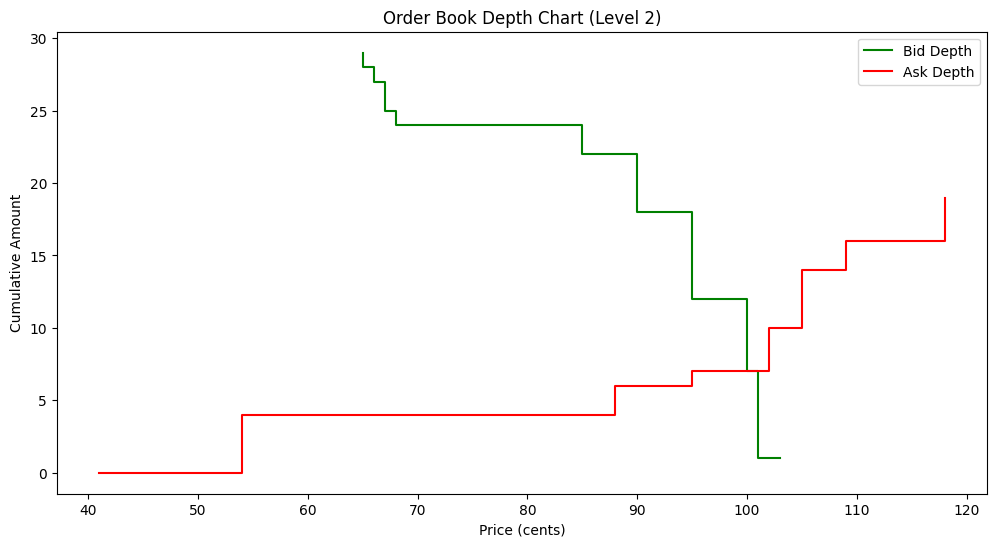

In [5]:
show_account_cash_balances(broker)
show_account_asset_balances(broker, asset)
average_bid_ask_spread_over_time(broker, asset)
depth_chart(broker, asset)